Build a regression model.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os
from datetime import datetime
import sqlite3 as sql

import seaborn
from pprint import pprint

os.chdir('../data')

con = sql.connect('Docomo_stations.db')

In [2]:
all_data_df = pd.read_sql_query(
    """
    SELECT *
    FROM stations s
    JOIN bike_info bi USING(station_name)
    JOIN area_counts ac USING(station_name)
    """
, con)

2

In [42]:
all_data_df.drop('index', axis=1, inplace=True)

earliest_time = pd.to_datetime(all_data_df['timestamp']).min()
all_data_df['timestamp'] = all_data_df['timestamp'].apply(lambda x: (pd.to_datetime(x)- earliest_time).seconds)


<Axes: >

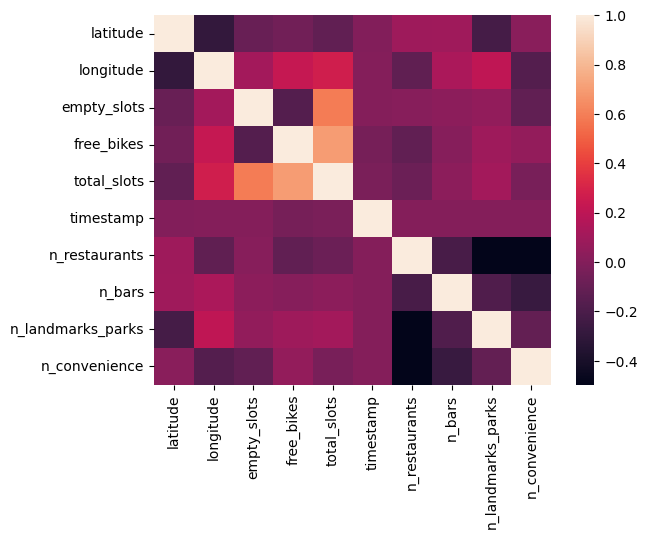

In [43]:
pcorr_matrix = all_data_df.corr(numeric_only=True)

seaborn.heatmap(pcorr_matrix, robust=True)

In [44]:
X = all_data_df[['latitude', 'longitude', 'empty_slots', 'total_slots', 'timestamp', 'n_restaurants', 'n_bars', 'n_landmarks_parks', 'n_convenience']]
X = sm.add_constant(X)
y = all_data_df[['free_bikes']]

lin_reg = sm.OLS(y,X)
model = lin_reg.fit()

Provide model output and an interpretation of the results. 

In [45]:
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:             free_bikes   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.999e+30
Date:                Sat, 10 Feb 2024   Prob (F-statistic):               0.00
Time:                        19:46:42   Log-Likelihood:             4.4252e+05
No. Observations:               15928   AIC:                        -8.850e+05
Df Residuals:                   15918   BIC:                        -8.849e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              5.684e-14   4.67e-1

The regression model has an R-Squared of 1.000. Of course, this is because it is predicting free_bikes using total_slots - empty_slots, which is exactly equal to free_bikes by construction. So these variables need to be dropped.

In [46]:
X = all_data_df[['latitude', 'longitude', 'timestamp', 'n_restaurants', 'n_bars', 'n_landmarks_parks', 'n_convenience']]
X = sm.add_constant(X)
y = all_data_df[['free_bikes']]

lin_reg = sm.OLS(y,X)
model = lin_reg.fit()

In [47]:
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:             free_bikes   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     165.7
Date:                Sat, 10 Feb 2024   Prob (F-statistic):          1.38e-237
Time:                        19:46:42   Log-Likelihood:                -56243.
No. Observations:               15928   AIC:                         1.125e+05
Df Residuals:                   15920   BIC:                         1.126e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -4771.0413    181.17

The adj. R-squared is now very low, as expected based on the correlation matrix. I will drop the two variables that have P-values above 0.2, n_restaurants and n_bars.

In [48]:
X = all_data_df[['latitude', 'longitude', 'timestamp', 'n_landmarks_parks', 'n_convenience']]
X = sm.add_constant(X)
y = all_data_df[['free_bikes']]

lin_reg = sm.OLS(y,X)
model = lin_reg.fit()

In [49]:
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:             free_bikes   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     231.6
Date:                Sat, 10 Feb 2024   Prob (F-statistic):          1.93e-239
Time:                        19:46:42   Log-Likelihood:                -56245.
No. Observations:               15928   AIC:                         1.125e+05
Df Residuals:                   15922   BIC:                         1.125e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -4825.6188    177.63

This unfortunately doesn't improve the adj. R-squared. All remaining statistics seem to have some significance in the result, so I will leave the model as is. It is clear that with the data collected there is little to no linear relationship between the number of bikes available and the latitude chosen x variables. It would likely be worth collecting data over a longer period of time to see if the timestamp variable becomes a better predictor. At the moment, it contains only 12 distinct values.

# Stretch

How can you turn the regression model into a classification model?

A classification model requires that the dependent variable is Boolean (or at least discrete). Since I am interested in the availability of bikes at each station, the simplest way to do this would be to convert the 'free_bikes' column to a Boolean, labeled False if there are 0 free_bikes and True if there are >0 free_bikes. I will once again drop the variables empty_slots and total_slots since they can determine free_bikes with 100% accuracy.

In [52]:
X = all_data_df[['latitude', 'longitude', 'timestamp', 'n_restaurants', 'n_bars', 'n_landmarks_parks', 'n_convenience']]
X = sm.add_constant(X)
y = all_data_df['free_bikes'] > 0

In [58]:
print(f"Number of data points: {len(y)}")
print(f"Data points where bikes are available: {sum(y)}")
print(f"Data points where bikes are not available: {len(y) - sum(y)}")

Number of data points: 15928
Data points where bikes are available: 12520
Data points where bikes are not available: 3408


In [59]:
log_reg = log_reg = sm.Logit(y, X)
model = log_reg.fit()

Optimization terminated successfully.
         Current function value: 0.506192
         Iterations 7


In [60]:
print_model = model.summary()
print(print_model)

                           Logit Regression Results                           
Dep. Variable:             free_bikes   No. Observations:                15928
Model:                          Logit   Df Residuals:                    15920
Method:                           MLE   Df Model:                            7
Date:                Sat, 10 Feb 2024   Pseudo R-squ.:                 0.02498
Time:                        20:05:31   Log-Likelihood:                -8062.6
converged:                       True   LL-Null:                       -8269.2
Covariance Type:            nonrobust   LLR p-value:                 3.670e-85
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -336.5929     55.187     -6.099      0.000    -444.758    -228.428
latitude              5.5432      0.425     13.056      0.000       4.711       6.375
longitude             1.

Since n_bars and n_landmarks_parks do not seem to significantly affect the availability of bikes, I will try dropping them from the model. Notably, this may not be the case if the analysis was done in a different timeframe.

In [64]:
X = all_data_df[['latitude', 'longitude', 'timestamp', 'n_restaurants', 'n_convenience']]
X = sm.add_constant(X)
y = all_data_df['free_bikes'] > 0

In [65]:
log_reg = log_reg = sm.Logit(y, X)
model = log_reg.fit()

Optimization terminated successfully.
         Current function value: 0.506264
         Iterations 7


In [66]:
print_model = model.summary()
print(print_model)

                           Logit Regression Results                           
Dep. Variable:             free_bikes   No. Observations:                15928
Model:                          Logit   Df Residuals:                    15922
Method:                           MLE   Df Model:                            5
Date:                Sat, 10 Feb 2024   Pseudo R-squ.:                 0.02484
Time:                        20:09:58   Log-Likelihood:                -8063.8
converged:                       True   LL-Null:                       -8269.2
Covariance Type:            nonrobust   LLR p-value:                 1.374e-86
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -339.0521     54.951     -6.170      0.000    -446.755    -231.350
latitude          5.6393      0.413     13.646      0.000       4.829       6.449
longitude         0.9989      0.358     

This did not seem to greatly alter the Log-Likelihood.